In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

try:
    import tensorflow as tf
    from tensorflow.keras import Input, Model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding, Flatten
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    TENSORFLOW_AVAILABLE = True
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("TensorFlow not available, using scikit-learn models")

# Define preprocessing functions inline
print("Using inline preprocessing functions")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")

TensorFlow version: 2.18.0
Using inline preprocessing functions
Libraries imported successfully


In [2]:
df = pd.read_csv('errors_day187_192.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['satellite_id', 'timestamp']).reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Satellites: {len(df['satellite_id'].unique())}")

df.head()

Dataset shape: (21504, 6)
Memory usage: 2.05 MB
Date range: 2025-07-06 00:00:00 to 2025-07-12 23:45:00
Satellites: 32


,satellite_id,timestamp,orbit_error_m,clock_error_ns,radial_error_m,ephemeris_age_hours
0,G01,2025-07-06 00:00:00,3.502946e+07,1.256349e+07,-2.311078e+07,0.00
1,G01,2025-07-06 00:15:00,3.537857e+07,1.256349e+07,-2.357213e+07,0.25
2,G01,2025-07-06 00:30:00,3.645217e+07,1.256349e+07,-2.502190e+07,0.50
3,G01,2025-07-06 00:45:00,3.812006e+07,1.256349e+07,-2.736062e+07,0.75
4,G01,2025-07-06 01:00:00,4.020278e+07,1.256349e+07,-3.042803e+07,1.00


In [3]:
print("Dataset Information:")
df.info()

print("\nStatistical Summary:")
df.describe()

print("\nMissing Values:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\nSatellite Distribution:")
satellite_counts = df['satellite_id'].value_counts().sort_index()
print(satellite_counts)

print("\nTemporal Distribution:")
df['day'] = df['timestamp'].dt.day
day_counts = df['day'].value_counts().sort_index()
print("Records per day:")
for day, count in day_counts.items():
    print(f"  Day {day}: {count:,} records")

print("\nTarget Variable Ranges:")
print(f"Orbit Error (m): {df['orbit_error_m'].min():.3f} to {df['orbit_error_m'].max():.3f}")
print(f"Clock Error (ns): {df['clock_error_ns'].min():.3f} to {df['clock_error_ns'].max():.3f}")
print(f"Radial Error (m): {df['radial_error_m'].min():.3f} to {df['radial_error_m'].max():.3f}")
print(f"Ephemeris Age (hrs): {df['ephemeris_age_hours'].min():.3f} to {df['ephemeris_age_hours'].max():.3f}")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21504 entries, 0 to 21503
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   satellite_id         21504 non-null  object        
 1   timestamp            21504 non-null  datetime64[ns]
 2   orbit_error_m        21504 non-null  float64       
 3   clock_error_ns       21408 non-null  float64       
 4   radial_error_m       21432 non-null  float64       
 5   ephemeris_age_hours  21504 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1008.1+ KB

Statistical Summary:

Missing Values:
                Missing Count  Missing Percentage
clock_error_ns             96            0.446429
radial_error_m             72            0.334821

Satellite Distribution:
satellite_id
G01    672
G02    672
G03    672
G04    672
G05    672
G06    672
G07    672
G08    672
G09    672
G10    672
G11 

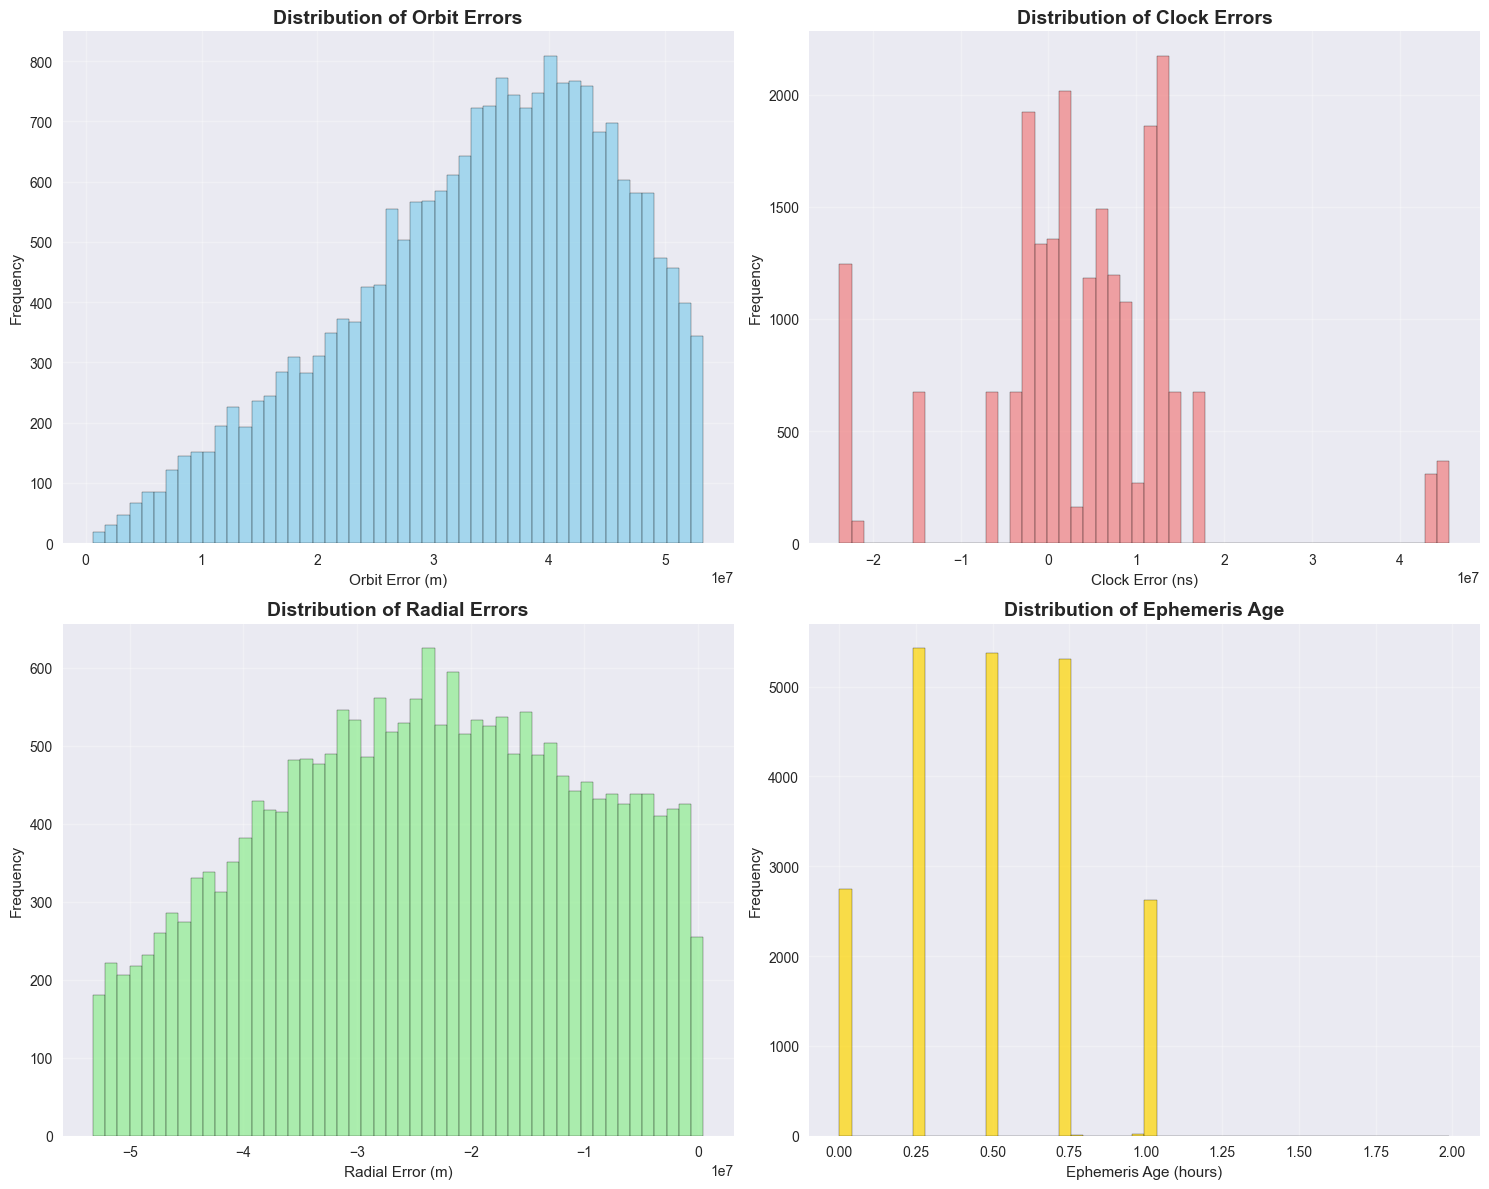


Correlation Matrix:


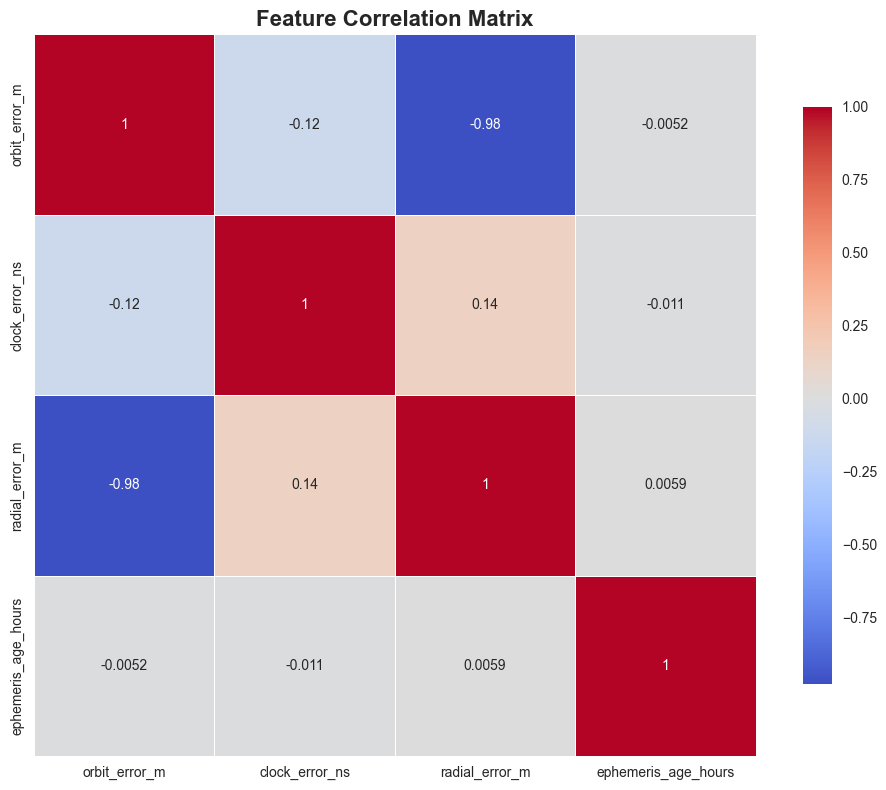

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].hist(df['orbit_error_m'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Orbit Errors', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Orbit Error (m)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(df['clock_error_ns'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Clock Errors', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Clock Error (ns)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(df['radial_error_m'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribution of Radial Errors', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Radial Error (m)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(df['ephemeris_age_hours'], bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('Distribution of Ephemeris Age', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Ephemeris Age (hours)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
correlation_matrix = df[['orbit_error_m', 'clock_error_ns', 'radial_error_m', 'ephemeris_age_hours']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [5]:
print("Data Cleaning:")
print(f"Initial dataset shape: {df.shape}")
initial_records = len(df)

print(f"\nMissing values check:")
nan_counts = df.isnull().sum()
for col, count in nan_counts.items():
    if count > 0:
        print(f"  {col}: {count} NaN values ({count/len(df)*100:.2f}%)")

print(f"\nInfinite values check:")
for col in df.select_dtypes(include=[np.number]).columns:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        print(f"  {col}: {inf_count} infinite values")

critical_columns = ['orbit_error_m', 'clock_error_ns', 'satellite_id', 'timestamp']
df_clean = df.dropna(subset=critical_columns)

print(f"\nAfter removing NaN values:")
print(f"  Records removed: {initial_records - len(df_clean)}")
print(f"  Remaining records: {len(df_clean)}")
print(f"  Data retention: {len(df_clean)/initial_records*100:.2f}%")

def detect_outliers(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
def detect_outliers(series, k=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    return (series < lower_bound) | (series > upper_bound)

print(f"\nOutlier Detection:")
outlier_columns = ['orbit_error_m', 'clock_error_ns', 'radial_error_m']
outlier_masks = {}
for col in outlier_columns:
    outliers = detect_outliers(df_clean[col])
    outlier_count = outliers.sum()
    outlier_percentage = outlier_count / len(df_clean) * 100
    outlier_masks[col] = outliers
    
    print(f"{col}:")
    print(f"  Outliers: {outlier_count} ({outlier_percentage:.2f}%)")

    if outlier_count > 0:
        print(f"  Range: {df_clean[col].min():.3f} to {df_clean[col].max():.3f}")
        print(f"  Outlier range: {df_clean.loc[outliers, col].min():.3f} to {df_clean.loc[outliers, col].max():.3f}")

combined_outliers = np.logical_or.reduce(list(outlier_masks.values()))
print(f"\nTotal rows with outliers: {combined_outliers.sum()} ({combined_outliers.sum()/len(df_clean)*100:.2f}%)")
df_clean['has_outlier'] = combined_outliers
df_clean['has_outlier'] = combined_outliers

print(f"\nData Quality Check:")
print(f"Final dataset shape: {df_clean.shape}")
print(f"No missing values in critical columns: {df_clean[critical_columns].isnull().sum().sum() == 0}")
print(f"Temporal continuity maintained: {df_clean['timestamp'].is_monotonic_increasing}")
print(f"All satellites present: {len(df_clean['satellite_id'].unique())} satellites")
print(f"All satellites present: {len(df_clean['satellite_id'].unique())} satellites")
df = df_clean.copy()
print(f"\nReady for preprocessing with {len(df):,} clean records")

Data Cleaning:
Initial dataset shape: (21504, 7)

Missing values check:
  clock_error_ns: 96 NaN values (0.45%)
  radial_error_m: 72 NaN values (0.33%)

Infinite values check:

After removing NaN values:
  Records removed: 96
  Remaining records: 21408
  Data retention: 99.55%

Outlier Detection:
orbit_error_m:
  Outliers: 13 (0.06%)
  Range: 636546.529 to 53295230.276
  Outlier range: 636546.529 to 1369971.010
clock_error_ns:
  Outliers: 2016 (9.42%)
  Range: -23821719.302 to 45685434.157
  Outlier range: -23821719.302 to 45685434.157
radial_error_m:
  Outliers: 0 (0.00%)

Total rows with outliers: 2029 (9.48%)

Data Quality Check:
Final dataset shape: (21408, 8)
No missing values in critical columns: True
Temporal continuity maintained: False
All satellites present: 32 satellites
All satellites present: 32 satellites

Ready for preprocessing with 21,408 clean records


In [6]:
print("Feature Engineering:")

df['hour'] = df['timestamp'].dt.hour
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['minute_of_day'] = df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute
df['satellite_constellation'] = df['satellite_id'].apply(lambda x: int(x[1:]) // 8)

window_size = 16
print("Calculating rolling statistics...")
rolling_features = []

for satellite in df['satellite_id'].unique():
    sat_data = df[df['satellite_id'] == satellite].copy()
    sat_data = sat_data.sort_values('timestamp')
    
    sat_data['orbit_error_ma_4h'] = sat_data['orbit_error_m'].rolling(window=window_size, min_periods=1).mean()
    sat_data['clock_error_ma_4h'] = sat_data['clock_error_ns'].rolling(window=window_size, min_periods=1).mean()
    sat_data['orbit_error_std_4h'] = sat_data['orbit_error_m'].rolling(window=window_size, min_periods=1).std()
    sat_data['clock_error_std_4h'] = sat_data['clock_error_ns'].rolling(window=window_size, min_periods=1).std()
    sat_data['orbit_error_diff'] = sat_data['orbit_error_m'].diff()
    sat_data['clock_error_diff'] = sat_data['clock_error_ns'].diff()
    
    rolling_features.append(sat_data)

df_featured = pd.concat(rolling_features, ignore_index=True)
df_featured = df_featured.sort_values(['satellite_id', 'timestamp']).reset_index(drop=True)

df_featured['orbit_error_diff'] = df_featured['orbit_error_diff'].fillna(0)
df_featured['clock_error_diff'] = df_featured['clock_error_diff'].fillna(0)
df_featured['orbit_error_std_4h'] = df_featured['orbit_error_std_4h'].fillna(0)
df_featured['clock_error_std_4h'] = df_featured['clock_error_std_4h'].fillna(0)

print(f"Feature engineering completed")
print(f"Original features: {df.shape[1]}")
print(f"Enhanced features: {df_featured.shape[1]}")
print(f"New features added: {df_featured.shape[1] - df.shape[1]}")

new_features = [col for col in df_featured.columns if col not in df.columns]
print(f"\nNew features: {new_features}")

df = df_featured.copy()

# Show feature summary
print(f"\n Feature Summary:")
print("="*50)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Total features: {len(df.columns)}")

Feature Engineering:
Calculating rolling statistics...
Feature engineering completed
Original features: 12
Enhanced features: 18
New features added: 6

New features: ['orbit_error_ma_4h', 'clock_error_ma_4h', 'orbit_error_std_4h', 'clock_error_std_4h', 'orbit_error_diff', 'clock_error_diff']

 Feature Summary:
Numeric features (15): ['orbit_error_m', 'clock_error_ns', 'radial_error_m', 'ephemeris_age_hours', 'day', 'hour', 'day_of_year', 'minute_of_day', 'satellite_constellation', 'orbit_error_ma_4h', 'clock_error_ma_4h', 'orbit_error_std_4h', 'clock_error_std_4h', 'orbit_error_diff', 'clock_error_diff']
Categorical features (1): ['satellite_id']
Total features: 18


In [7]:
print("Train/Validation Split:")

df['day'] = df['timestamp'].dt.day
max_day = df['day'].max()
train_df = df[df['day'] < max_day].copy()
val_df = df[df['day'] == max_day].copy()

print(f"Training set:")
print(f"  Period: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"  Records: {len(train_df):,}")
print(f"  Days: {sorted(train_df['day'].unique())}")
print(f"  Satellites: {len(train_df['satellite_id'].unique())}")

print(f"\nValidation set:")
print(f"  Period: {val_df['timestamp'].min()} to {val_df['timestamp'].max()}")
print(f"  Records: {len(val_df):,}")
print(f"  Days: {sorted(val_df['day'].unique())}")
print(f"  Satellites: {len(val_df['satellite_id'].unique())}")

print(f"\nData Integrity Check:")
print(f"  No temporal overlap: {train_df['timestamp'].max() < val_df['timestamp'].min()}")
print(f"  All satellites in both sets: {set(train_df['satellite_id'].unique()) == set(val_df['satellite_id'].unique())}")
print(f"  Total records: {len(train_df) + len(val_df)} (original: {len(df)})")

print(f"\nDay-based split complete: {len(train_df):,} training and {len(val_df):,} validation records")

Train/Validation Split:
Training set:
  Period: 2025-07-06 00:00:00 to 2025-07-11 23:45:00
  Records: 18,336
  Days: [np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11)]
  Satellites: 32

Validation set:
  Period: 2025-07-12 00:00:00 to 2025-07-12 23:45:00
  Records: 3,072
  Days: [np.int32(12)]
  Satellites: 32

Data Integrity Check:
  No temporal overlap: True
  All satellites in both sets: True
  Total records: 21408 (original: 21408)

Day-based split complete: 18,336 training and 3,072 validation records


In [8]:
print("Preprocessing with Standard Sklearn:")

# Simple preprocessing approach
lookback_window = 12
core_columns = ['satellite_id', 'timestamp', 'orbit_error_m', 'clock_error_ns', 'ephemeris_age_hours']
train_core = train_df[core_columns].copy()
val_core = val_df[core_columns].copy()

# Encode satellite IDs
sat_encoder = LabelEncoder()
sat_encoder.fit(train_core['satellite_id'])
train_core['satellite_encoded'] = sat_encoder.transform(train_core['satellite_id'])
val_core['satellite_encoded'] = sat_encoder.transform(val_core['satellite_id'])

# Scale numerical features
feature_cols = ['orbit_error_m', 'clock_error_ns', 'ephemeris_age_hours']
scaler = StandardScaler()
scaler.fit(train_core[feature_cols])
train_core[feature_cols] = scaler.transform(train_core[feature_cols])
val_core[feature_cols] = scaler.transform(val_core[feature_cols])

# Create sequences
def create_sequences(data, lookback=12):
    sequences_X = []
    sequences_y = []
    
    for sat in data['satellite_encoded'].unique():
        sat_data = data[data['satellite_encoded'] == sat].sort_values('timestamp')
        
        if len(sat_data) < lookback + 1:
            continue
            
        features = sat_data[['orbit_error_m', 'clock_error_ns', 'ephemeris_age_hours']].values
        targets = sat_data[['orbit_error_m', 'clock_error_ns']].values
        
        for i in range(lookback, len(sat_data)):
            X_seq = features[i-lookback:i]
            y_seq = targets[i]
            
            sequences_X.append(X_seq)
            sequences_y.append(y_seq)
    
    return np.array(sequences_X), np.array(sequences_y)

print(f"Creating sequences with lookback window: {lookback_window}")
X_train, y_train = create_sequences(train_core, lookback_window)
X_val, y_val = create_sequences(val_core, lookback_window)

print(f"\nData shapes:")
print(f"  X_train: {X_train.shape} (samples, time_steps, features)")
print(f"  y_train: {y_train.shape} (samples, targets)")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")

print(f"\nPreprocessing complete using StandardScaler and LabelEncoder")

Preprocessing with Standard Sklearn:
Creating sequences with lookback window: 12

Data shapes:
  X_train: (17952, 12, 3) (samples, time_steps, features)
  y_train: (17952, 2) (samples, targets)
  X_val: (2688, 12, 3)
  y_val: (2688, 2)

Preprocessing complete using StandardScaler and LabelEncoder


In [9]:
print("Checking for NaN values in processed data...")
print(f"X_train has NaN: {np.isnan(X_train).any()}")
print(f"y_train has NaN: {np.isnan(y_train).any()}")
print(f"X_val has NaN: {np.isnan(X_val).any()}")
print(f"y_val has NaN: {np.isnan(y_val).any()}")

if np.isnan(X_train).any() or np.isnan(y_train).any():
    print("\nCleaning data by removing NaN values...")
    valid_indices = ~(np.isnan(X_train).any(axis=(1,2)) | np.isnan(y_train).any(axis=1))
    X_train = X_train[valid_indices]
    y_train = y_train[valid_indices]
    
    valid_indices_val = ~(np.isnan(X_val).any(axis=(1,2)) | np.isnan(y_val).any(axis=1))
    X_val = X_val[valid_indices_val]
    y_val = y_val[valid_indices_val]
    
    print(f"Data cleaned. Final shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
else:
    print("No NaN values found. Data is clean.")

Checking for NaN values in processed data...
X_train has NaN: False
y_train has NaN: False
X_val has NaN: False
y_val has NaN: False
No NaN values found. Data is clean.


In [10]:
print("Preprocessing Summary:")
print(f"Training sequences: {X_train.shape}")
print(f"Validation sequences: {X_val.shape}")
print(f"Features per timestep: {X_train.shape[2]}")
print(f"Sequence length: {X_train.shape[1]} timesteps")
print(f"Target variables: {y_train.shape[1] if len(y_train.shape) > 1 else 1}")
print(f"Satellites encoded: {len(sat_encoder.classes_)}")
print(f"Feature scaling: StandardScaler applied")

Preprocessing Summary:
Training sequences: (17952, 12, 3)
Validation sequences: (2688, 12, 3)
Features per timestep: 3
Sequence length: 12 timesteps
Target variables: 2
Satellites encoded: 32
Feature scaling: StandardScaler applied


In [18]:
def create_sequences(X, y, time_steps=10):
    """Convert tabular (or 3D) data into GRU-ready 3D sequences"""
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        seq_x = X[i:(i + time_steps)]
        seq_y = y[i + time_steps]

        # Flatten if sequence is >2D (e.g., (time, 12, 3) -> (time, 36))
        if seq_x.ndim > 2:
            seq_x = seq_x.reshape(seq_x.shape[0], -1)

        Xs.append(seq_x)
        ys.append(seq_y)
    return np.array(Xs), np.array(ys)

time_steps = 10  # sliding window length (tunable)
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)

print(f"GRU Training shape: {X_train_seq.shape}, {y_train_seq.shape}")
print(f"GRU Validation shape: {X_val_seq.shape}, {y_val_seq.shape}")

GRU Training shape: (17942, 10, 36), (17942, 2)
GRU Validation shape: (2678, 10, 36), (2678, 2)


In [19]:
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("X_val_seq shape:", X_val_seq.shape)
print("y_val_seq shape:", y_val_seq.shape)


X_train_seq shape: (17942, 10, 36)
y_train_seq shape: (17942, 2)
X_val_seq shape: (2678, 10, 36)
y_val_seq shape: (2678, 2)


In [21]:
gru_model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    GRU(64, activation='tanh', return_sequences=False),  # final GRU, no sequences
    Dropout(0.2),
    Dense(y_train_seq.shape[1], activation='linear')  # matches 2 targets
])


gru_model.summary()
gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 10, 128)        │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,122 (395.01 KB)

 Trainable params: 101,122 (395.01 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1957 - mae: 0.2931 - val_loss: 0.0901 - val_mae: 0.1521
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0616 - mae: 0.1629 - val_loss: 0.0755 - val_mae: 0.1360
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0553 - mae: 0.1478 - val_loss: 0.0668 - val_mae: 0.1205
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0479 - mae: 0.1379 - val_loss: 0.0663 - val_mae: 0.1227
Epoch 5/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0436 - mae: 0.1335 - val_loss: 0.0620 - val_mae: 0.1097
Epoch 6/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0441 - mae: 0.1308 - val_loss: 0.0620 - val_mae: 0.1252
Epoch 7/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0456 - mae: 0.1305 - val_loss: 0.0647 - val_mae: 0.1252
Epoch 8/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0441 - mae: 0.1306 - val_loss: 0.0585 - val_mae: 0.1087
Epoch 9/100
281/281 ━━━━━━━━━━━━━━━━━━━━

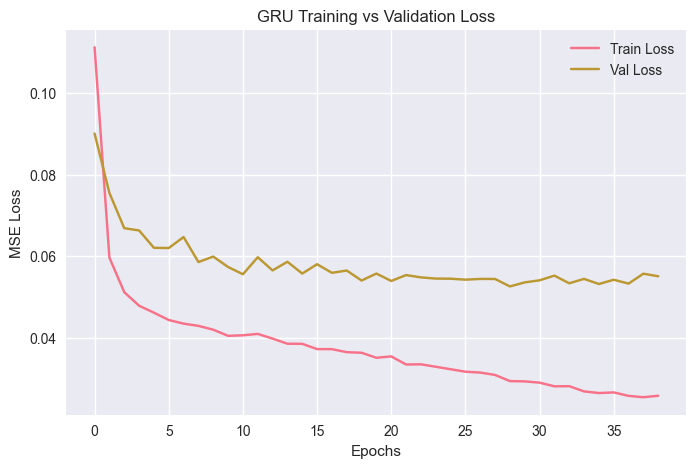

In [23]:
plt.figure(figsize=(8,5))
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("GRU Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


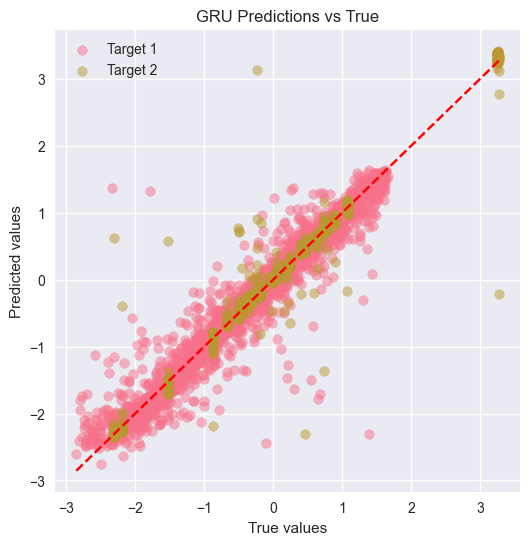

In [ ]:
y_pred_seq = gru_model.predict(X_val_seq)

plt.figure(figsize=(6,6))
plt.scatter(y_val_seq[:,0], y_pred_seq[:,0], alpha=0.5, label="Target 1")
plt.scatter(y_val_seq[:,1], y_preb_seq[:,1], alpha=0.5, label="Target 2")
plt.plot([y_val_seq.min(), y_val_seq.max()],
         [y_val_seq.min(), y_val_seq.max()], 'r--')
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.legend()
plt.title("GRU Predictions vs True")
plt.grid(True)
plt.show()


In [29]:
gru_model.save('gru_model.keras')

Time Series Transformer 

In [39]:
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / tf.maximum(tf.abs(y_true), tf.keras.backend.epsilon()))) * 100

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-Head Self Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])              # Residual connection
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed Forward Network
    ffn = Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(inputs.shape[-1]),
    ])
    x2 = ffn(x)
    x2 = Dropout(dropout)(x2)
    x = Add()([x, x2])                  # Residual connection
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

In [40]:
def build_transformer(time_steps, num_features, num_targets):
    inputs = Input(shape=(time_steps, num_features))
    
    # stack a few transformer blocks
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)
    
    # Global pooling across timesteps
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    
    # Final regression layer
    outputs = Dense(num_targets, activation="linear")(x)
    
    model = Model(inputs, outputs)
    return model

In [41]:
transformer_model = build_transformer(time_steps=10, num_features=36, num_targets=2)

transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[mae, mse, rmse, mape, r2_score]
)


transformer_model.summary()



Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 10, 36)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 36)    │     37,668 │ input_layer_12[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 10, 36)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 10, 36)    │          0 │ dropout_28[0][0], │
│                     │                   │            │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 36)    │         72 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 10, 36)    │      9,380 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 10, 36)    │          0 │ sequential_9[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 10, 36)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 36)    │         72 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 36)    │     37,668 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 10, 36)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 10, 36)    │          0 │ dropout_31[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 36)    │         72 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 10, 36)    │      9,380 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 10, 36)    │          0 │ sequential_10[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 10, 36)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 36)    │         72 │ add_15[0][0]    

 Total params: 94,458 (368.98 KB)

 Trainable params: 94,458 (368.98 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history_transformer = transformer_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.3026 - mae: 0.3842 - mape: 294.4903 - mse: 0.3026 - r2_score: 0.7039 - rmse: 0.5134 - val_loss: 0.1755 - val_mae: 0.2257 - val_mape: 153.1635 - val_mse: 0.1750 - val_r2_score: 0.7078 - val_rmse: 0.3889
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.1058 - mae: 0.2232 - mape: 144.4528 - mse: 0.1058 - r2_score: 0.8902 - rmse: 0.3223 - val_loss: 0.1578 - val_mae: 0.2052 - val_mape: 158.7005 - val_mse: 0.1573 - val_r2_score: 0.7236 - val_rmse: 0.3682
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0853 - mae: 0.2002 - mape: 172.0779 - mse: 0.0853 - r2_score: 0.9129 - rmse: 0.2895 - val_loss: 0.1592 - val_mae: 0.2205 - val_mape: 190.9861 - val_mse: 0.1590 - val_r2_score: 0.7368 - val_rmse: 0.3717
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0813 - mae: 0.1934 - mape: 115.3845 - mse: 0.0813 - r2_score: 0.9162 - rmse: 0.2819 - val_loss: 0.1519 - val_mae: 0.2131 - val_mape: 151.2

In [43]:
import numpy as np

# ---- Take a few samples from validation set ----
X_sample = X_val_seq[:5]   # 5 samples
y_true_sample = y_val_seq[:5]

# ---- Make predictions ----
y_pred_sample = transformer_model.predict(X_sample)

# ---- Compute metrics ----
mae_val = mae(y_true_sample, y_pred_sample).numpy()
mse_val = mse(y_true_sample, y_pred_sample).numpy()
rmse_val = rmse(y_true_sample, y_pred_sample).numpy()
mape_val = mape(y_true_sample, y_pred_sample).numpy()
r2_val = r2_score(y_true_sample, y_pred_sample).numpy()

# ---- Print results ----
print("Sample Metrics on 5 validation samples:")
print(f"MAE  : {mae_val:.4f}")
print(f"MSE  : {mse_val:.4f}")
print(f"RMSE : {rmse_val:.4f}")
print(f"MAPE : {mape_val:.2f}%")
print(f"R²   : {r2_val:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Sample Metrics on 5 validation samples:
MAE  : 0.0878
MSE  : 0.0116
RMSE : 0.1078
MAPE : 69.52%
R²   : 0.8052


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


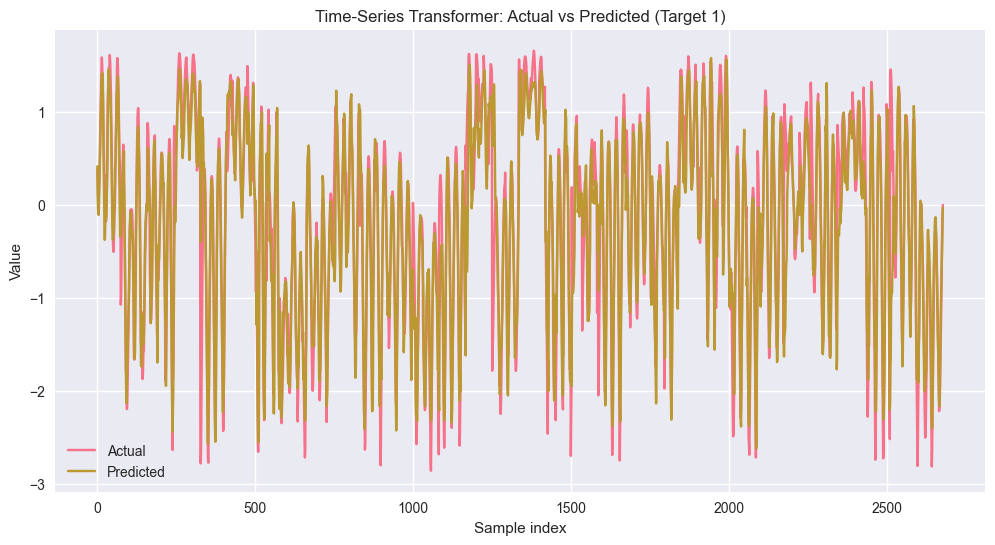

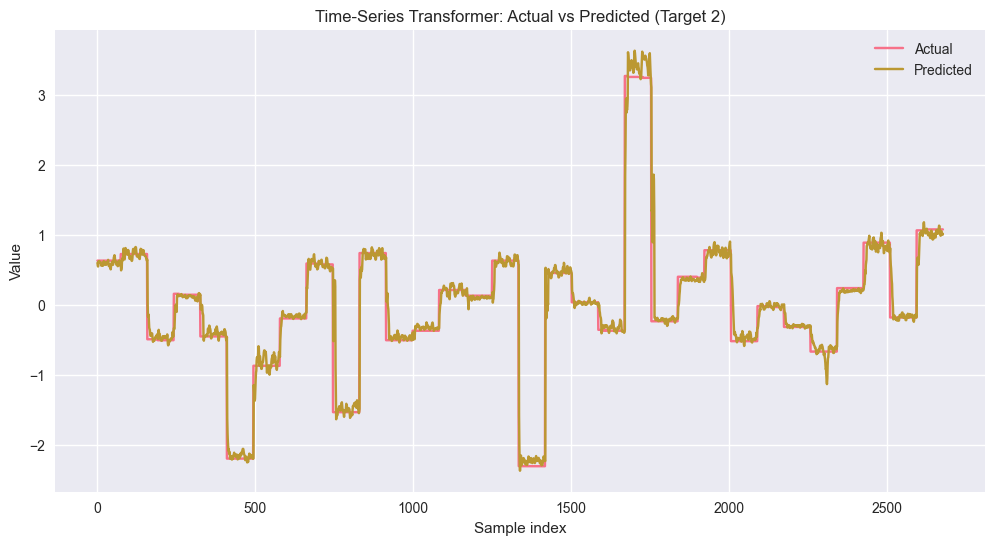

In [46]:
# Predict on validation set
y_pred = transformer_model.predict(X_val_seq)
y_true = y_val_seq

import matplotlib.pyplot as plt

# Plot the first target dimension
plt.figure(figsize=(12, 6))
plt.plot(y_true[:, 0], label='Actual')
plt.plot(y_pred[:, 0], label='Predicted')
plt.title('Time-Series Transformer: Actual vs Predicted (Target 1)')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the second target dimension
plt.figure(figsize=(12, 6))
plt.plot(y_true[:, 1], label='Actual')
plt.plot(y_pred[:, 1], label='Predicted')
plt.title('Time-Series Transformer: Actual vs Predicted (Target 2)')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


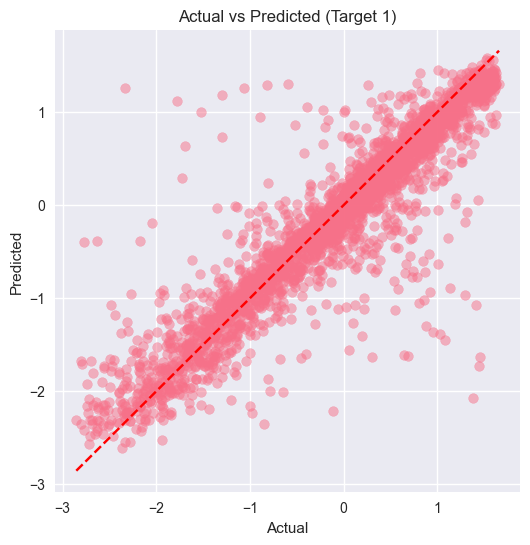

In [47]:
plt.figure(figsize=(6,6))
plt.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.5)
plt.plot([y_true[:,0].min(), y_true[:,0].max()], 
         [y_true[:,0].min(), y_true[:,0].max()], 
         'r--')  # perfect prediction line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (Target 1)')
plt.grid(True)
plt.show()


In [45]:
transformer_model.save('time_series_transformer_model.keras')

Tabular Transformer 

In [54]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / tf.maximum(tf.abs(y_true), tf.keras.backend.epsilon()))) * 100

def tabular_transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self Attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])  # Residual
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # Feed-Forward Network
    ffn = Sequential([
        Dense(ff_dim, activation='relu'),
        Dense(inputs.shape[-1])
    ])
    x2 = ffn(x)
    x2 = Dropout(dropout)(x2)
    x = Add()([x, x2])  # Residual
    x = LayerNormalization(epsilon=1e-6)(x)
    
    return x

In [60]:
def build_tabular_transformer(num_features, num_targets, num_blocks=2):
    inputs = Input(shape=(num_features, 1))
    x = inputs
    for _ in range(num_blocks):
        x = tabular_transformer_block(x, head_size=32, num_heads=4, ff_dim=64, dropout=0.1)
    
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_targets, activation='linear')(x)
    
    model = Model(inputs, outputs)
    return model

# ---- Prepare Data ----
X_train_tab = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[1]*X_train_seq.shape[2], 1)
X_val_tab   = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[1]*X_val_seq.shape[2], 1)

y_train_tab = y_train_seq
y_val_tab   = y_val_seq

In [63]:
tab_transformer_model = build_tabular_transformer(num_features=360, num_targets=2)

tab_transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mse',
    metrics=[mae, mse, rmse, mape, r2_score]  # reuse custom metrics
)


In [65]:
history_tab = tab_transformer_model.fit(
    X_train_tab, y_train_tab,
    validation_data=(X_val_tab, y_val_tab),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 115s 410ms/step - loss: 0.9982 - mae: 0.7580 - mape: 103.6552 - mse: 0.9982 - r2_score: -0.0067 - rmse: 0.9961 - val_loss: 1.0546 - val_mae: 0.7830 - val_mape: 102.9297 - val_mse: 1.0564 - val_r2_score: -0.4161 - val_rmse: 0.9698
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 112s 397ms/step - loss: 0.9979 - mae: 0.7559 - mape: 102.2264 - mse: 0.9979 - r2_score: -0.0079 - rmse: 0.9963 - val_loss: 1.0545 - val_mae: 0.7830 - val_mape: 103.0861 - val_mse: 1.0563 - val_r2_score: -0.4162 - val_rmse: 0.9698
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 87s 308ms/step - loss: 1.0092 - mae: 0.7624 - mape: 104.7256 - mse: 1.0092 - r2_score: -0.0072 - rmse: 1.0020 - val_loss: 1.0569 - val_mae: 0.7829 - val_mape: 99.9997 - val_mse: 1.0588 - val_r2_score: -0.4157 - val_rmse: 0.9709
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 97s 347ms/step - loss: 1.0003 - mae: 0.7578 - mape: 103.2882 - mse: 1.0003 - r2_score: -0.0064 - rmse: 0.9970 - val_loss: 1.0568 - val_mae: 0.7829 - val

In [66]:
tab_transformer_model.save('tabular_transformer_model.keras')

84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step


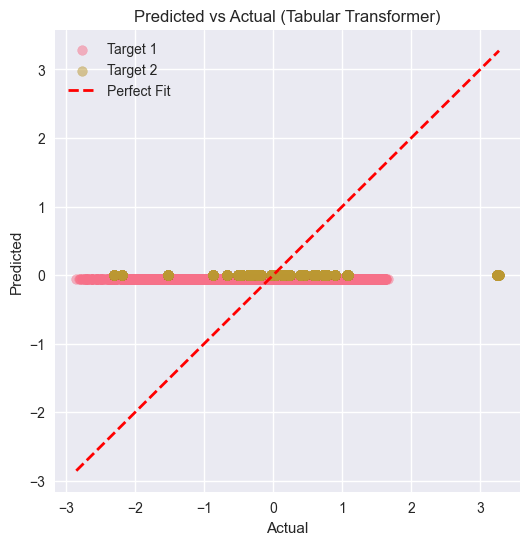

In [67]:
# Predict on validation data
y_pred_tab = tab_transformer_model.predict(X_val_tab)
plt.figure(figsize=(6,6))
plt.scatter(y_val_seq[:, 0], y_pred_tab[:, 0], alpha=0.5, label="Target 1")
plt.scatter(y_val_seq[:, 1], y_pred_tab[:, 1], alpha=0.5, label="Target 2")
plt.plot([y_val_seq.min(), y_val_seq.max()],
         [y_val_seq.min(), y_val_seq.max()],
         'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (Tabular Transformer)")
plt.legend()
plt.grid(True)
plt.show()

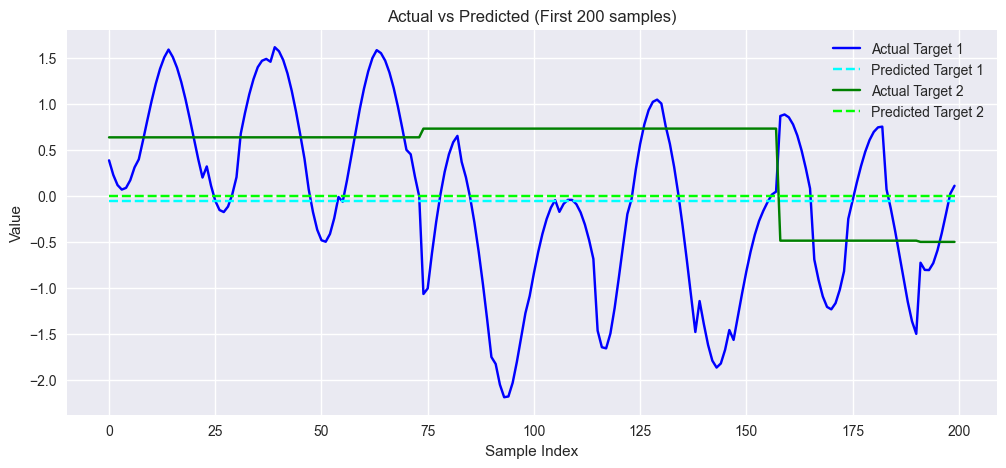

In [68]:
plt.figure(figsize=(12,5))
plt.plot(y_val_seq[:200, 0], label="Actual Target 1", color="blue")
plt.plot(y_pred_tab[:200, 0], label="Predicted Target 1", color="cyan", linestyle="dashed")

plt.plot(y_val_seq[:200, 1], label="Actual Target 2", color="green")
plt.plot(y_pred_tab[:200, 1], label="Predicted Target 2", color="lime", linestyle="dashed")

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Actual vs Predicted (First 200 samples)")
plt.legend()
plt.grid(True)
plt.show()
